#BasicLibrary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

##Load Train/Test

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

##Preprocess

In [3]:
# preprocessing

### mean imputations 
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace=True)

### reducing fat content to only two categories 
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat']) 
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], ['Regular']) 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat']) 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])

## for calculating establishment year
train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year'] 
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year']

### missing values for size
train['Outlet_Size'].fillna('Small',inplace=True)
test['Outlet_Size'].fillna('Small',inplace=True)

### label encoding cate. var.
col = ['Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Fat_Content']
test['Item_Outlet_Sales'] = 0
combi = train.append(test)
number = LabelEncoder()
for i in col:
 combi[i] = number.fit_transform(combi[i].astype('str'))
 combi[i] = combi[i].astype('int')
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]
test.drop('Item_Outlet_Sales',axis=1,inplace=True)

## removing id variables 
training = train.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
testing = test.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
y_train = training['Item_Outlet_Sales']
training.drop('Item_Outlet_Sales',axis=1,inplace=True)

features = training.columns
target = 'Item_Outlet_Sales'

X_train, X_test = training, testing

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(features)

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')


In [ ]:
X_train

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,0,0.016047,249.8092,14,1,0,1
1,5.920,1,0.019278,48.2692,4,1,2,2
2,17.500,0,0.016760,141.6180,14,1,0,1
3,19.200,1,0.000000,182.0950,15,2,2,0
4,8.930,0,0.000000,53.8614,26,0,2,1
...,...,...,...,...,...,...,...,...
8518,6.865,0,0.056783,214.5218,26,0,2,1
8519,8.380,1,0.046982,108.1570,11,2,1,1
8520,10.600,0,0.035186,85.1224,9,2,1,1
8521,7.210,1,0.145221,103.1332,4,1,2,2


#Importing Pretrained models

In [4]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

##Testing models

In [5]:
model_factory = [
 RandomForestRegressor(),
 XGBRegressor(nthread=1),
 #MLPRegressor(),
 Ridge(),
 BayesianRidge(),
 ExtraTreesRegressor(),
 ElasticNet(),
 KNeighborsRegressor(),
 GradientBoostingRegressor()
]

for model in model_factory:
 model.seed = 42
 num_folds = 3

 scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')
 score_description = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

 print('{model:25} CV-5 RMSE: {score}'.format(
  model=model.__class__.__name__,
  score=score_description
  ))

RandomForestRegressor     CV-5 RMSE:  1147.84 (+/- 26314.99)
[12:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor              CV-5 RMSE:  1084.86 (+/- 26774.60)
Ridge                     CV-5 RMSE:  1206.41 (+/- 54020.12)
BayesianRidge             CV-5 RMSE:  1206.56 (+/- 52695.34)
ExtraTreesRegressor       CV-5 RMSE:  1192.87 (+/- 18360.86)
ElasticNet                CV-5 RMSE:  1259.18 (+/- 89803.16)
KNeighborsRegressor       CV-5 RMSE:  1245.71 (+/- 37275.84)
GradientBoostingRegressor CV-5 RMSE:  1086.32 (+/- 19556.96)


#Pseudo-labeling 

In [6]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
 '''
 Sci-kit learn wrapper for creating pseudo-lebeled estimators.
 '''

 def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
  '''
  @sample_rate - percent of samples used as pseudo-labelled data
  from the unlabelled dataset
  '''
  assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'

  self.sample_rate = sample_rate
  self.seed = seed
  self.model = model
  self.model.seed = seed

  self.unlabled_data = unlabled_data
  self.features = features
  self.target = target

 def get_params(self, deep=True):
  return {
  "sample_rate": self.sample_rate,
  "seed": self.seed,
  "model": self.model,
  "unlabled_data": self.unlabled_data,
  "features": self.features,
  "target": self.target
  }

 def set_params(self, **parameters):
  for parameter, value in parameters.items():
   setattr(self, parameter, value)
  return self

 def fit(self, X, y):
  '''
  Fit the data using pseudo labeling.
  '''
  augemented_train = self.__create_augmented_train(X, y)
  self.model.fit(
   augemented_train[self.features],
   augemented_train[self.target]
  )
  return self

 def __create_augmented_train(self, X, y):
  '''
  Create and return the augmented_train set that consists
  of pseudo-labeled and labeled data.
  '''
  num_of_samples = int(len(self.unlabled_data) * self.sample_rate)

# Train the model and creat the pseudo-labels
  self.model.fit(X, y)
  pseudo_labels = self.model.predict(self.unlabled_data[self.features])

# Add the pseudo-labels to the test set
  pseudo_data = self.unlabled_data.copy(deep=True)
  pseudo_data[self.target] = pseudo_labels

# Take a subset of the test set with pseudo-labels and append in onto
 # the training set
  sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
  temp_train = pd.concat([X, y], axis=1)
  augemented_train = pd.concat([sampled_pseudo_data, temp_train])

  return shuffle(augemented_train)

 def predict(self, X):
  '''
  Returns the predicted values.
  '''
  return self.model.predict(X)

 def get_model_name(self):
  return self.model.__class__.__name__

In [7]:
model_factory = [
 XGBRegressor(nthread=1),
 PseudoLabeler(
 XGBRegressor(nthread=1),
 test,
 features,
 target,
 sample_rate=0.3
 ),
]

for model in model_factory:
 model.seed = 42
 num_folds = 8
 
 scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
 score_description = "MSE: %0.4f (+/- %0.4f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

 print('{model:25} CV-{num_folds} {score_cv}'.format(
  model=model.__class__.__name__,
  num_folds=num_folds,
  score_cv=score_description
  ))

XGBRegressor              CV-8 MSE: 1083.2088 (+/- 122498.1182)
PseudoLabeler             CV-8 MSE: 1082.1352 (+/- 124208.6614)


##Dependance on sample rate

In [10]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
 return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
 RandomForestRegressor(n_jobs=1),
 XGBRegressor(),
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 5

for model in model_factory:
 model_name = model.get_model_name()
 print('%s' % model_name)

results[model_name] = list()
for sample_rate in sample_rates:
 model.sample_rate = sample_rate
 
 # Calculate the CV-3 R2 score and store it
 scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
 results[model_name].append(np.sqrt(scores.mean()*-1))

RandomForestRegressor
XGBRegressor


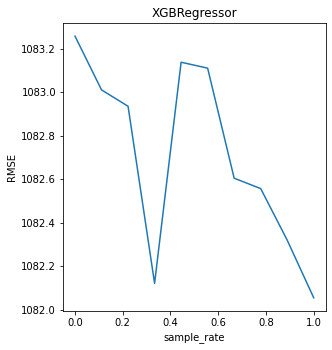

In [11]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items(): 
 plt.subplot(3, 3, i)
 i += 1
 
 plt.plot(sample_rates, performance)
 plt.title(model_name)
 plt.xlabel('sample_rate')
 plt.ylabel('RMSE')


plt.show()